In [1]:
import nltk
from nltk.corpus import brown

many to many

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /Users/apple/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [3]:
corpus = brown.tagged_sents(tagset='universal')

In [4]:
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [5]:
len(corpus)

57340

In [8]:
inputs = []
targets = []

for sentence_tag_paris in corpus:
    tokens = []
    target = []
    for token, tag in sentence_tag_paris:
        tokens.append(token)
        target.append(tag)
    inputs.append(tokens)
    targets.append(target)

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [10]:
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, test_size=0.3)

In [11]:
#convert sentence to sequence
MAX_VOCAB_SIZE = None

should_lowercase = False #beacuse capitalization might be useful -> dff meanings
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower = should_lowercase,
    oov_token='UNK',
    )
#otherwise unknown tokens will be removed and len(input) ≠ len(target)

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [13]:
#get word -> integer mapping
word2idx = word_tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 47513 unique tokens.


In [14]:
#convert a list of list to single list
def flatten(list_of_lists):
    flattened = [val for sublist in list_of_lists for val in sublist]
    return flattened

In [15]:
all_train_targets = set(flatten(train_targets))
all_train_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [16]:
all_test_targets = set(flatten(test_targets))
all_test_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [17]:
all_train_targets == all_test_targets

True

In [18]:
# convert target to sequences
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)

train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

#save for later
train_targets_int_unpadded = train_targets_int
test_targets_unpadded = test_targets_int

In [19]:
#befroe padding, find max length to avoid truncate any inputs
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max((maxlen_test, maxlen_train))
T

180

In [21]:
#pad sequence for N*T matrix
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print('Shape of train targets tensor:', train_targets_int.shape)

test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print('Shape of test targets tensor:', test_targets_int.shape)

Shape of data train tensor: (40138, 180)
Shape of data test tensor: (17202, 180)
Shape of train targets tensor: (40138, 180)
Shape of test targets tensor: (17202, 180)


In [22]:
K = len(tag_tokenizer.word_index)+1
K

13

In [24]:
#model
D = 32

i = Input(shape = (T,))
x = Embedding(V+1, D, mask_zero=True)(i) #ignore zeros (0,0,1,2,3) = (' ',' ', 'I', 'love', 'cat')
#setting mask_zero = true make CPU and GPU slower
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i,x)

In [25]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer = 'adam',
    metrics = ['accuracy']
    )

In [26]:
r = model.fit(
    train_inputs_int, 
    train_targets_int, 
    epochs=5,
    validation_data=(test_inputs_int, test_targets_int)
    )

Epoch 1/5
1255/1255 [==============================] - 355s 275ms/step - loss: 0.0552 - accuracy: 0.8524 - val_loss: 0.0124 - val_accuracy: 0.9650
Epoch 2/5
1255/1255 [==============================] - 362s 288ms/step - loss: 0.0081 - accuracy: 0.9780 - val_loss: 0.0098 - val_accuracy: 0.9712
Epoch 3/5
1255/1255 [==============================] - 297s 237ms/step - loss: 0.0050 - accuracy: 0.9863 - val_loss: 0.0094 - val_accuracy: 0.9734
Epoch 4/5
1255/1255 [==============================] - 213s 170ms/step - loss: 0.0037 - accuracy: 0.9896 - val_loss: 0.0098 - val_accuracy: 0.9731
Epoch 5/5
1255/1255 [==============================] - 207s 165ms/step - loss: 0.0029 - accuracy: 0.9920 - val_loss: 0.0103 - val_accuracy: 0.9726


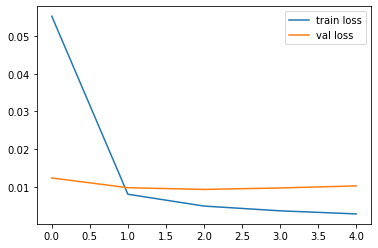

In [27]:
#plot loss per iteration
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend()
plt.show();

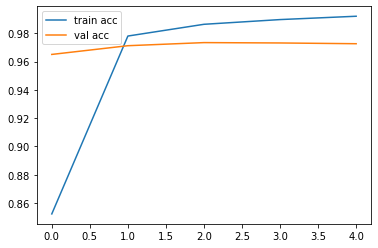

In [28]:
#accuracy per iteration
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show();

In [31]:
# true model acc - above include padding

# len
train_length = []
for sentence in train_inputs:
    train_length.append(len(sentence))

test_length = []
for sentence in test_inputs:
    test_length.append(len(sentence))

In [35]:
train_probs = model.predict(train_inputs_int)
train_pred = []

for prob,length in zip(train_probs, train_length):
    probs_ = prob[-length:]
    preds = np.argmax(probs_, axis = 1)
    train_pred.append(preds)

#flatten
flat_train_pred = flatten(train_pred)
flat_train_targets = flatten(train_targets_int_unpadded)

1255/1255 [==============================] - 39s 31ms/step


In [38]:
test_probs = model.predict(test_inputs_int)
test_pred = []

for prob,length in zip(test_probs, test_length):
    probs_ = prob[-length:]
    preds = np.argmax(probs_, axis = 1)
    test_pred.append(preds)

#flatten
flat_test_pred = flatten(test_pred)
flat_test_targets = flatten(test_targets_unpadded)

538/538 [==============================] - 18s 33ms/step


In [40]:
from sklearn.metrics import accuracy_score, f1_score

print('Train acc: ', accuracy_score(flat_train_targets, flat_train_pred))
print('Test acc: ', accuracy_score(flat_test_targets, flat_test_pred))

print('Train F1-score:', f1_score(flat_train_targets, flat_train_pred, average = 'macro'))
print('Test F1-score:', f1_score(flat_test_targets, flat_test_pred, average = 'macro'))

Train acc:  0.9942018170258414
Test acc:  0.9725677867768882
Train F1-score: 0.9863481941762027
Test F1-score: 0.9335738977520579


In [41]:
#compare model to baseline

from collections import Counter

def most_common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

In [42]:
token2tags = {k: [] for k,v in word2idx.items()}

#remove UNK token
del token2tags['UNK']

for tokens, tags in zip(train_inputs, train_targets):
    for token, tag in zip(tokens, tags):
        if should_lowercase:
            token = token.lower()
        if token in token2tags:
            token2tags[token].append(tag)
            
token2tag = {k: most_common(v) for k,v in token2tags.items()}

In [47]:
train_pred = []

for sentences in train_inputs:
    pred = []
    for token in sentences:
        if should_lowercase:
            token = token.lower()
        predicted_tag = token2tag[token]
        pred.append(predicted_tag)
    train_pred.append(pred)

flat_train_pred = flatten(train_pred)
flat_train_targets = flatten(train_targets)

In [48]:
test_pred = []

for sentences in test_inputs:
    pred = []
    for token in sentences:
        predicted_tag = token2tag.get(token, 'INCORRECT')
        pred.append(predicted_tag)
    test_pred.append(pred)

flat_test_pred = flatten(test_pred)
flat_test_targets = flatten(test_targets)

In [50]:
print('Train acc: ', accuracy_score(flat_train_targets, flat_train_pred))
print('Test acc: ', accuracy_score(flat_test_targets, flat_test_pred))

print('Train F1-score:', f1_score(flat_train_targets, flat_train_pred, average = 'macro'))
print('Test F1-score:', f1_score(flat_test_targets, flat_test_pred, average = 'macro'))

Train acc:  0.9574059390871666
Test acc:  0.9278316890554013
Train F1-score: 0.9376912262026872
Test F1-score: 0.8267028144579983
